# Word2Vec

In [1]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np
import re
import collections
import copy
import datetime
import traceback

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import gensim

# import dlnlputils
# from dlnlputils.data import , , , \
#     PaddedSequenceDataset, Embeddings
# from dlnlputils.pipeline import train_eval_loop, predict_with_model
# from dlnlputils.visualization import plot_vectors

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

## Загрузка данных и подготовка корпуса

In [2]:
full_dataset = list(pd.read_csv('data/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

6 ounces milk
Plain yogurt, preferably sheep’s milk, for serving
1/2 bunch parsley, stemmed, washed and dried
Sprigs of fresh herbs (optional)
1/2 teaspoon chili powder
Chopped fresh fennel fronds
Freshly ground black pepper to taste
1 teaspoon dark soy sauce
3 tablespoons finely chopped onion
1/2 cup plus 1 tablespoon sugar


In [10]:
# токенизируем
def add_fake_token(word2id, token='<PAD>'):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')


TOKEN_RE = re.compile(r'[\w\d]+')

def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def character_tokenize(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

ounces milk
plain yogurt preferably sheep milk serving
bunch parsley stemmed washed dried
sprigs fresh herbs optional
teaspoon chili powder
chopped fresh fennel fronds
freshly ground black pepper taste
teaspoon dark sauce
tablespoons finely chopped onion
plus tablespoon sugar


In [13]:
# строим словарь

def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

vocabulary, word_doc_freq = build_vocabulary(train_tokenized, 
                                             max_doc_freq=0.9, 
                                             min_count=5, 
                                             pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2283
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('tablespoon', 8), ('fresh', 9)]


In [14]:
# отображаем в номера токенов

def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

21 60
207 167 78 1504 60 138
145 42 198 160 43
82 9 410 50
2 136 74
3 9 188 807
11 7 22 5 10
2 174 55
1 16 3 35
44 8 23


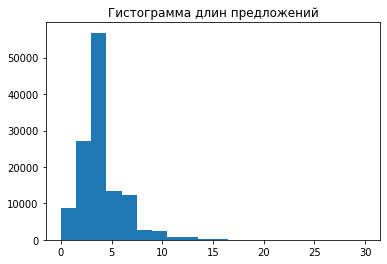

In [15]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [19]:
MAX_SENTENCE_LEN = 20 #оптимальная длина, выбранная по гистограмме

def ensure_length(txt, out_len, pad_value):
    """
    Выравнивает текст до необходимой длины
    """
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    """
    Класс, выравнивающий длины предложений для передачи в неронную сеть
    """
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target

train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)

test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([21, 60,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]), tensor(0))


<ipython-input-19-ab43dff62116>:33: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  target = torch.tensor(self.targets[item], dtype=torch.long)


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [21]:
def make_diag_mask(size, radius):
    """
    Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали
    
    Маска необходима для наложения на предложения и получения токенов контекстных слов.
    """
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

# **Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [57]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        # матрица центральных векторов эмбеддингов слов
        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        # инициализация равномерным шумом - для того, чтобы  длина вектора примерно равнялась 1
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        # указываем, что не нужно учить вектор для фиктовного слова
        self.center_emb.weight.data[0] = 0

        # матрица контекстных векторов
        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        # матрица масок
        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """
        Будет использоваться для обучения модели (не стандартное использование forward)
        
        Parameter:
        sentences - Batch x MaxSentLength - набор предложений для обучения
        
        """
        batch_size = sentences.shape[0]
        # получение центральных эмбеддингов - для каждого токена в предложении получаем его эмбеддинг
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        
        #получение контекстных эмбеддингов и их транспонирвоание
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        # bmm - матричное произведение для каждой пары матриц в батче - физ смысл: оценка сходства для каждой пары токенов
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        # сигмойда для оценки вероятности того, что два слова встретятся вместе
        positive_probs = torch.sigmoid(positive_sims) 

        # увеличить оценку вероятности встретить эти пары слов вместе
        # формирование маски
        positive_mask = self.positive_sim_mask.to(positive_sims.device) # перевод на тот же девайс
        positive_loss = F.binary_cross_entropy(
            positive_probs * positive_mask,  # занулениие оценки вероятностей для токенов вне окна
            target=positive_mask.expand_as(positive_probs) # дублирует маску для каждого элемента, как указание реальных таргетов
        )

        # выбрать случайные "отрицательные" слова
        
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        #оценка сходствва между центральным словом и случайными словами
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits( # кросс-энтропия вместе с сигмойдой (более стабильный)
            negative_sims,
            target=negative_sims.new_zeros(negative_sims.shape) # нули в виде таргета
        )

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [58]:
trainer = SkipGramNegativeSamplingTrainer(vocab_size=len(vocabulary), 
                                          emb_size=100, 
                                          sentence_len=MAX_SENTENCE_LEN,
                                          radius=5, 
                                          negative_samples_n=25)

In [60]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, 
                    train_dataset, 
                    val_dataset, 
                    criterion,
                    lr=1e-4, 
                    epoch_n=10, 
                    batch_size=32,
                    device=None, 
                    early_stopping_patience=10, 
                    l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    
    # перенос модели на устройство вычисления
    device = torch.device(device)
    model.to(device)

    # создение оптимизатора
    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), 
                                     lr=lr, 
                                     weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), 
                                   lr=lr)

    # настройка изменения скорости обучения
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    # создаём dataloader - класс pytorch, позволяющий в многопоточном режиме собирать датасеты
    train_dataloader = data_loader_ctor(train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    
    val_dataloader = data_loader_ctor(val_dataset, 
                                      batch_size=batch_size, 
                                      shuffle=False,
                                      num_workers=dataloader_workers_n)
    
    # инициализация сохранения лучших параметров 
    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    # цикл обучения
    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train() # перевод модели в режим обучения, необх. для корр. dropout и batchnorm

            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                # указанное количество шагов в эпоху
                if batch_i > max_batches_per_epoch_train:
                    break

                # копирование данных на устройство модели
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x) # прямой проход
                loss = criterion(pred, batch_y) # критерий ошибки

                model.zero_grad() # очистка градиентов с прошлого шага
                loss.backward() # находим новые градиенты
                optimizer.step() # делаем градиентный шаг

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)

            
            ### Валидация

            model.eval() # перевод модели в режим предсказания
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad(): # выключение сохранения градиентов - экономит ресурсы
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            # сохранение лучшей модели
            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            # если задано расписание - обновить lr
            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        
        # обработка исключений
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
            
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [66]:
lr_scheduler_ctor = (
    lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 
                                                             patience=1, 
                                                             verbose=True)
)

best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            criterion=no_loss,
                                            lr=1e-2,
                                            epoch_n=20,
                                            batch_size=8,
                                            device='cuda',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lr_scheduler_ctor)

Device: cuda
Эпоха 0


<ipython-input-19-ab43dff62116>:33: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  target = torch.tensor(self.targets[item], dtype=torch.long)


Эпоха: 2001 итераций, 1.70 сек
Среднее значение функции потерь на обучении 0.8734154959489917
Среднее значение функции потерь на валидации 0.8788537049151497
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 1.30 сек
Среднее значение функции потерь на обучении 0.8761733947009935
Среднее значение функции потерь на валидации 0.8785461252870084
Новая лучшая модель!

Эпоха 2
Эпоха: 2001 итераций, 1.56 сек
Среднее значение функции потерь на обучении 0.8767997640958135
Среднее значение функции потерь на валидации 0.8788841353542132

Эпоха 3
Эпоха: 2001 итераций, 1.41 сек
Среднее значение функции потерь на обучении 0.8761722355232067
Среднее значение функции потерь на валидации 0.8787179426834464
Epoch     4: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 4
Эпоха: 2001 итераций, 1.02 сек
Среднее значение функции потерь на обучении 0.8716781111969345
Среднее значение функции потерь на валидации 0.8740614599641898
Новая лучшая модель!

Эпоха 5
Эпоха: 2001 итераций, 1.45 сек
Среднее з

In [ ]:
torch.save(trainer.state_dict(), 'models/sgns.pth')

In [ ]:
trainer.load_state_dict(torch.load('models/sgns.pth'))

## Исследуем характеристики полученных векторов

In [69]:
class Embeddings:
    """
    Класс для удобной работы с эмбеддингами
    """
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        # нормирование на евклидову норму
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4) 
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def most_similar(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors


embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [70]:
embeddings.most_similar('chicken')

[('chicken', 0.99993813),
 ('stock', 0.59114283),
 ('duck', 0.56481475),
 ('turkey', 0.5606057),
 ('breast', 0.5037479),
 ('beef', 0.50205433),
 ('breasts', 0.49541062),
 ('thighs', 0.46647796),
 ('veal', 0.46329796),
 ('broth', 0.45386797)]

In [72]:
embeddings.analogy(a1='cake', b1='cacao', a2='cheese')

[('cacao', 1.0605507),
 ('cheese', 0.93083644),
 ('sheep', 0.86282176),
 ('blanco', 0.66917986),
 ('aged', 0.62945586),
 ('brined', 0.62859),
 ('dandelion', 0.6120976),
 ('creamy', 0.587269),
 ('country', 0.5844902),
 ('strawberry', 0.58285856)]

In [73]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


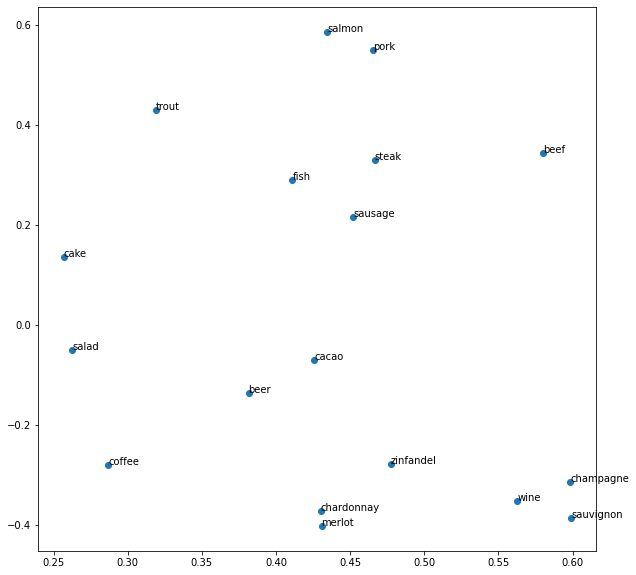

In [77]:
def plot_vectors(vectors, labels, how='tsne', ax=None):
    if how == 'tsne':
        projections = TSNE().fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]

    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))


fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

Изменения в библиотеке https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [90]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, vector_size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, epochs=10)

In [91]:
word2vec.wv.most_similar('chicken')

[('simmering', 0.722916305065155),
 ('pheasant', 0.7011006474494934),
 ('thighs', 0.6959019303321838),
 ('drumsticks', 0.6846168041229248),
 ('breasts', 0.6842592358589172),
 ('duck', 0.6837055683135986),
 ('defatted', 0.6810212731361389),
 ('stock', 0.6603814959526062),
 ('turkey', 0.6572012305259705),
 ('rabbit', 0.6563793420791626)]

In [97]:
gensim_words = [w for w in test_words if w in word2vec.wv.key_to_index.keys()]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

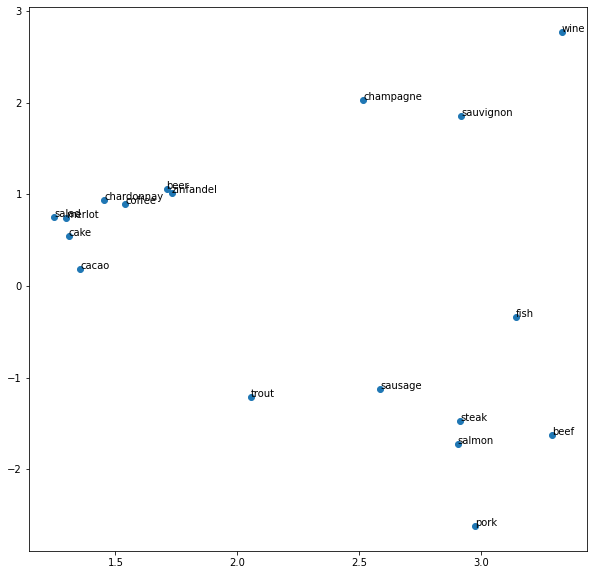

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [99]:
import gensim.downloader as api

In [100]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [105]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 3.7% 61.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 6.0% 99.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.3% 137.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.6% 175.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.8% 213.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 15.1% 251.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 17.3% 287.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.6% 325.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 21.9% 363.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 24.2% 402.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.5% 439.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 28.7% 477.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 30.9% 513.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 33.3% 553.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.5% 589.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 37.8% 628.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 40.1% 666.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 42.4% 704.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 44.7% 742.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.9% 780.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 49.4% 820.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.6% 858.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.9% 896.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 56.2% 934.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.5% 972.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 60.8% 1010.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.1% 1048.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.3% 1086.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.6% 1124.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.9% 1162.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 72.2% 1200.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================================-------------] 74.5% 1238.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.8% 1276.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 79.0% 1314.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.3% 1352.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.6% 1390.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 85.9% 1427.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 88.1% 1465.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.4% 1503.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 92.7% 1541.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.0% 1579.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 97.3% 1617.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 99.7% 1657.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [106]:
pretrained.most_similar('cheese')

[('cheeses', 0.7788999676704407),
 ('cheddar', 0.7627597451210022),
 ('goat_cheese', 0.7297402024269104),
 ('Cheese', 0.7286962270736694),
 ('cheddar_cheese', 0.725513756275177),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805710792541504),
 ('cheddar_cheeses', 0.6694672107696533),
 ('Camembert', 0.6623162031173706),
 ('gruyere', 0.6615148186683655)]

In [107]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077577233314514),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696190118789673),
 ('person', 0.48637545108795166)]

In [109]:
pretrained_words = [w for w in test_words if w in pretrained.key_to_index.keys()]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

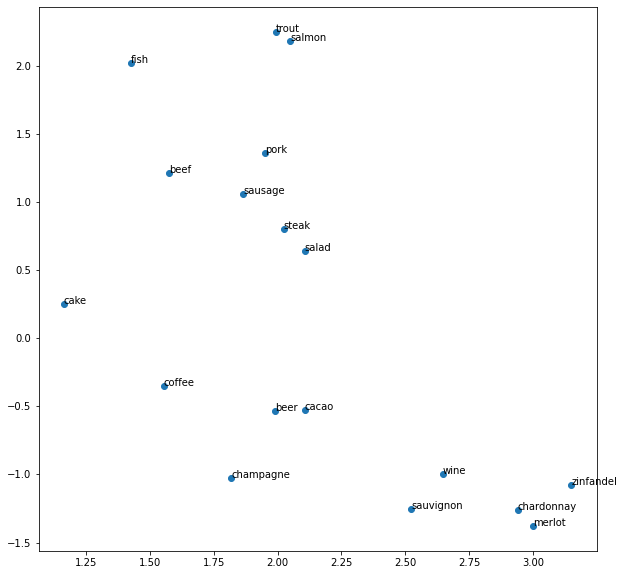

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают